Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:11:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Dummy Classifier Evaluation
Accuracy: 0.6417569880205363
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
 [[1125    0]
 [ 628    0]]
----------------------------------------

Logistic Regression Evaluation
Accuracy: 0.6417569880205363
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
 [[1125    0]
 [ 628    0]]
Log Loss: 0.6545428078928477
----------------------------------------

k-NN Classifier Evaluation
Accuracy: 0.5687393040501997
Precision: 0.35046728971962615
Recall: 0.23885350318471338
F1 Score: 0.2840909090909091
Confusion Matrix:
 [[847 278]
 [478 150]]
----------------------------------------

Decision Tree Evaluation
Accuracy: 0.6406160867084997
Precision: 0.4444444444444444
Recall: 0.012738853503184714
F1 Score: 0.02476780185758514
Confusion Matrix:
 [[1115   10]
 [ 620    8]]
Log Loss: 0.6527610494422712
----------------------------------------

Random Forest Evaluation
Accuracy: 0.6417569880205363
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Ma

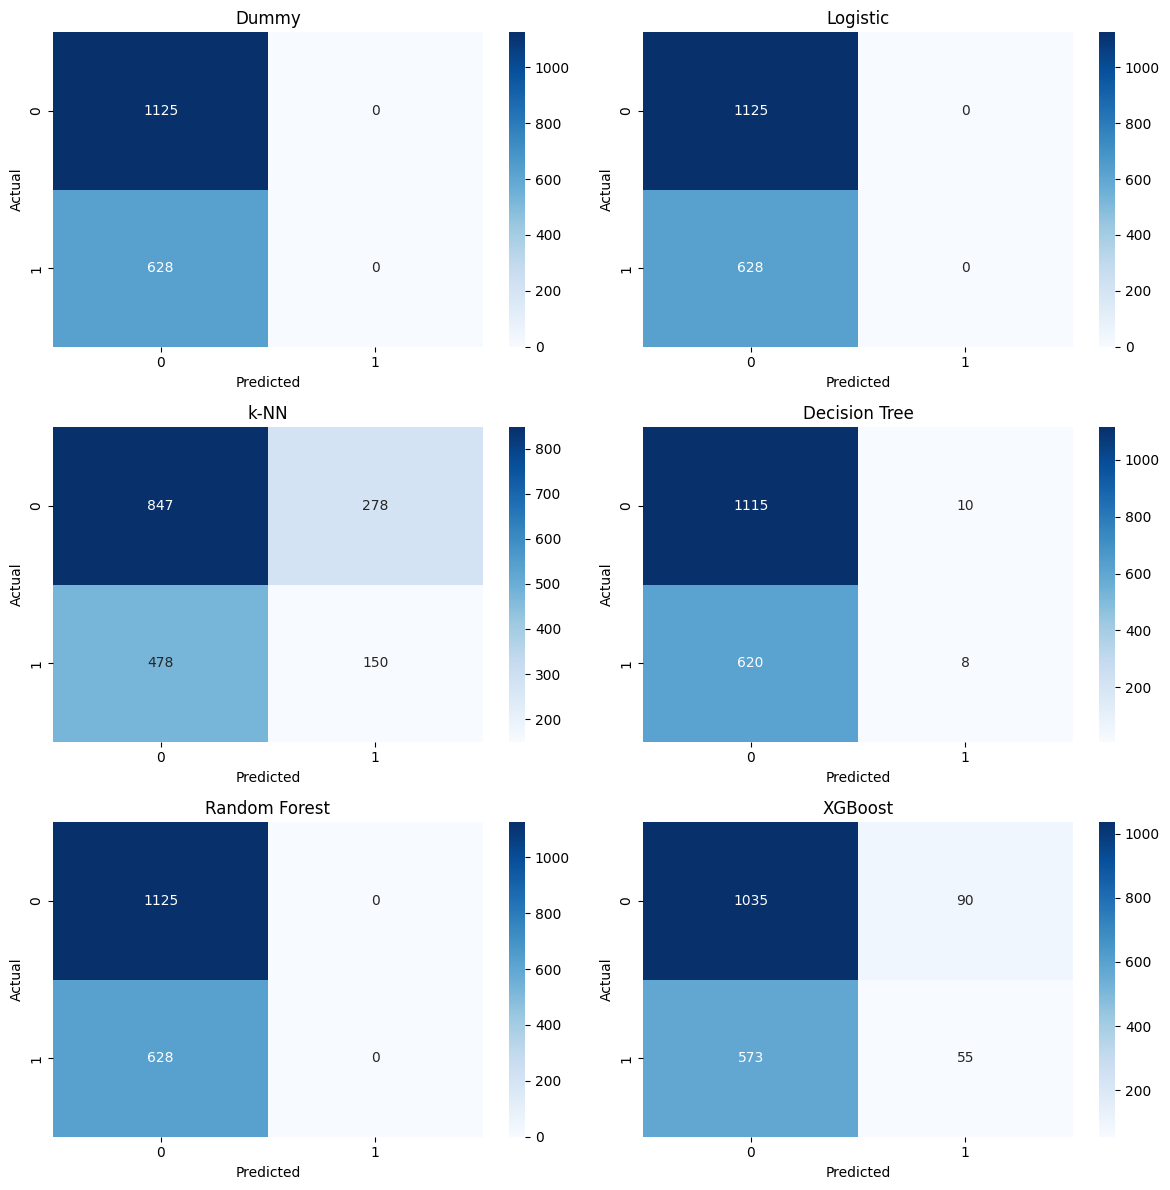

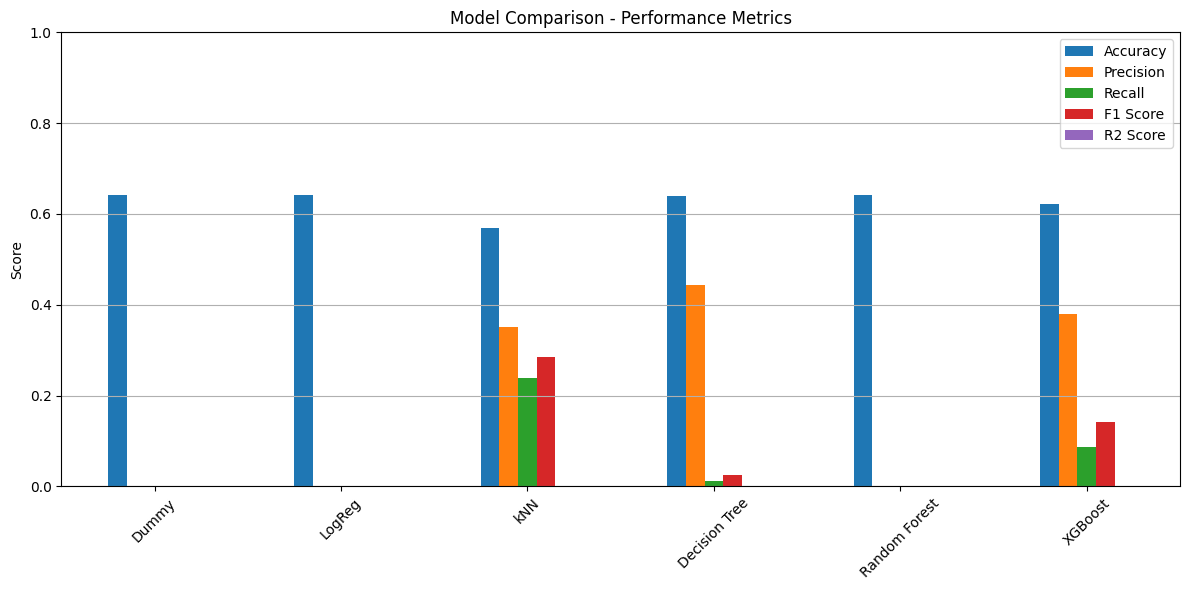

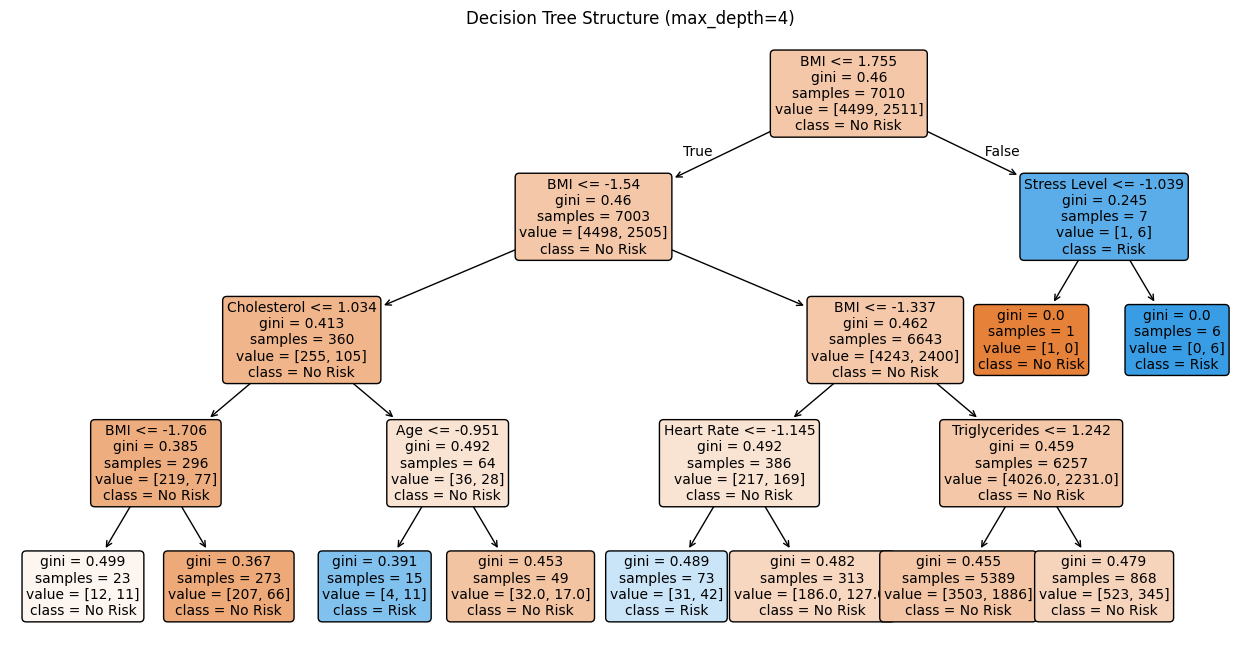

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, log_loss, mean_squared_error, mean_absolute_error,
    r2_score
)

import xgboost as xgb


# ----------------------------
# 📥 2. Load and Preprocess Dataset
# ----------------------------

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Milestone 4 Data/Datasets/heart_attack_prediction_dataset.csv')

# Drop irrelevant columns
df = df.drop(columns=['Patient ID', 'Country', 'Continent', 'Hemisphere', 'Blood Pressure'])

# One-hot encode categorical features
encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
encoded = encoder.fit_transform(df[['Sex', 'Diet']])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['Sex', 'Diet']), index=df.index)
df = pd.concat([df.drop(columns=['Sex', 'Diet']), encoded_df], axis=1)


# ----------------------------
# 📊 3. Define Features, Scale and Split
# ----------------------------

X = df.drop("Heart Attack Risk", axis=1)
y = df["Heart Attack Risk"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


# ----------------------------
# 🤖 4. Train Models
# ----------------------------

# Dummy Classifier
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
dummy_preds = dummy.predict(X_test)

# Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
log_preds = logreg.predict(X_test)
log_probs = logreg.predict_proba(X_test)

# k-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
knn_preds = knn.predict(X_test)

# Decision Tree
tree = DecisionTreeClassifier(max_depth=4, random_state=42)
tree.fit(X_train, y_train)
tree_preds = tree.predict(X_test)
tree_probs = tree.predict_proba(X_test)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
rf_probs = rf.predict_proba(X_test)

# XGBoost
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1,
                               use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
xgb_probs = xgb_model.predict_proba(X_test)


# ----------------------------
# 📋 5. Evaluation Function
# ----------------------------

def evaluate_model(name, y_true, y_pred, y_prob=None):
    print(f"\n{name} Evaluation")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, zero_division=0))
    print("Recall:", recall_score(y_true, y_pred, zero_division=0))
    print("F1 Score:", f1_score(y_true, y_pred, zero_division=0))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    if y_prob is not None:
        print("Log Loss:", log_loss(y_true, y_prob))
    print("-" * 40)

# Evaluate all models
evaluate_model("Dummy Classifier", y_test, dummy_preds)
evaluate_model("Logistic Regression", y_test, log_preds, log_probs)
evaluate_model("k-NN Classifier", y_test, knn_preds)
evaluate_model("Decision Tree", y_test, tree_preds, tree_probs)
evaluate_model("Random Forest", y_test, rf_preds, rf_probs)
evaluate_model("XGBoost", y_test, xgb_preds, xgb_probs)


# ----------------------------
# 🔥 6. Visualize Confusion Matrices
# ----------------------------

def plot_cm(ax, y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set(title=title, xlabel='Predicted', ylabel='Actual')

fig, axes = plt.subplots(3, 2, figsize=(12, 12))
model_preds = [dummy_preds, log_preds, knn_preds, tree_preds, rf_preds, xgb_preds]
titles = ['Dummy', 'Logistic', 'k-NN', 'Decision Tree', 'Random Forest', 'XGBoost']

for ax, pred, title in zip(axes.flat, model_preds, titles):
    plot_cm(ax, y_test, pred, title)

plt.tight_layout()
plt.show()


# ----------------------------
# 📊 7. Compare Model Metrics
# ----------------------------

models = ['Dummy', 'LogReg', 'kNN', 'Decision Tree', 'Random Forest', 'XGBoost']
metrics_df = pd.DataFrame({
    'Accuracy': [accuracy_score(y_test, p) for p in model_preds],
    'Precision': [precision_score(y_test, p, zero_division=0) for p in model_preds],
    'Recall': [recall_score(y_test, p, zero_division=0) for p in model_preds],
    'F1 Score': [f1_score(y_test, p, zero_division=0) for p in model_preds],
    'R2 Score': [r2_score(y_test, p) for p in model_preds]
}, index=models)

metrics_df.plot(kind='bar', figsize=(12, 6))
plt.title("Model Comparison - Performance Metrics")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# ----------------------------
# 🌳 8. Visualize Decision Tree
# ----------------------------

plt.figure(figsize=(16, 8))
plot_tree(tree, feature_names=X.columns, class_names=['No Risk', 'Risk'], filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree Structure (max_depth=4)")
plt.show()
